<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/calculate_petrofit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Images 424x424 are used for calculation of Petrosian radii. Make sure to upload or copy from Google Drive `curated_imgs_large.zip`. You can generate them with the appropriate script in the repository.

If you want visualization only,  you can use much smaller `curated_imgs.zip`.

In [ ]:
!cp ./drive/MyDrive/curated_imgs_large.zip ./
!unzip -q -o curated_imgs_large.zip && echo "UNZIPPED" || "FAIL"

UNZIPPED


Install the libraries needed for processing

In [ ]:
!pip install astropy==5.3.4
!pip install aplpy
!pip install petrofit

try:
  import astropy
  import petrofit
  import photutils
  from google.colab import output
  output.clear()
except:
  print('ERROR')
finally:
  print('COMPLETE')

COMPLETE


Generate petrossian radii by `petrofit`. Results are saved to `output_imgs_folder` and `processed_table`.

The table is saved after each iteration, so that you can stop processing at any point.

================ processed 8 ===============
only the last result is shown, for all results see ./out_images


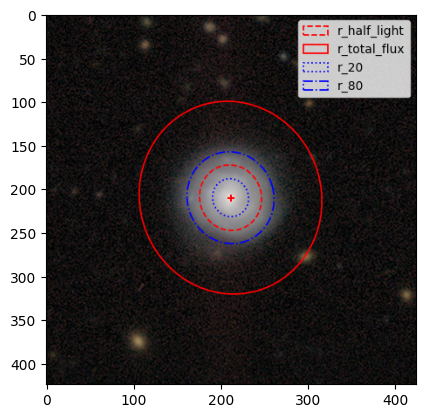

Deblending:   0%|          | 0/506 [00:00<?, ?it/s]

Execution stopped by user. Exiting gracefully.


In [ ]:
import astropy
import petrofit as pf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from photutils.utils import calc_total_error
from astropy.stats import sigma_clipped_stats
import os
import pandas as pd
from google.colab import output


original_table = 'curated_dataset.parquet'
processed_table = 'petrofit_processed.parquet'
input_imgs_folder = './curated_imgs_large'
output_imgs_folder = './out_images'


def reset_table(original_table, processed_table):
  df = pd.read_parquet(original_table)
  bootstrapped_df = df.sample(frac=1) # just shuffle
  bootstrapped_df = bootstrapped_df.assign(processed=False,
                                           r_80=0.0, theta=0.0, elong=0.0,
                                           position_X=0.0, position_Y=0.0)
  bootstrapped_df.reset_index()
  bootstrapped_df.to_parquet(processed_table)


def create_overlay(name, save_to):
  raw_image = Image.open(name)
  image = raw_image.convert("L")
  image_data = np.array(image).astype("float64")
  rms_fake = np.zeros_like(image_data)
  gain_fake= np.ones_like(image_data)

  err = calc_total_error(data=image_data, bkg_error=rms_fake, effective_gain=gain_fake)
  image_mean, image_median, image_stddev = sigma_clipped_stats(image_data, sigma=3)

  threshold = image_stddev * 3
  npixels = 2**2

  vmax = 0.05 # Use the image std as max and min of all plots
  vmin = - vmax

  cat, segm, segm_deblend = pf.make_catalog(image_data, threshold=threshold,
                                            deblend=True, npixels=npixels,
                                            contrast=0.00, plot=False,
                                            vmax=vmax, vmin=vmin)
  # Sort and select object of interest in the catalog
  sorted_idx_list = pf.order_cat(cat, key='area', reverse=True)
  idx = sorted_idx_list[0] # index 0 is largest
  source = cat[idx]  # get source from the catalog

  # Max aperture radius
  max_pix = image_data.shape[0]

  r_list = pf.make_radius_list(max_pix=max_pix, n=max_pix)

  # Photomerty
  flux_arr, area_arr, error_arr = pf.source_photometry(
      source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
      image_data, # Image as 2D array
      segm_deblend, # Deblended segmentation map of image
      r_list, # list of aperture radii
      # Options
      error=err, # Error image (optional)
      cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius
      bg_sub=True, # Subtract background
      sigma=3, sigma_type='clip', # Fit a 2D plane to pixels within 3 sigma of the mean
      plot=False # Show plot with max and min defined above
  )

  image_x_0, image_y_0 = pf.get_source_position(source)
  p = pf.Petrosian(r_list, area_arr, flux_arr, flux_err=error_arr, eta=0.2)

  h, w = image_data.shape[:2]
  r_80 = p._calculate_fraction_to_r(.8)[0]
  elong = pf.get_source_elong(source)
  position = pf.get_source_position(source)
  theta = pf.get_source_theta(source)
  parameters = {
    'r_80': r_80,
    'elong': elong,
    'position_X': position[0] - w//2,
    'position_Y': position[1] - h//2,
    'theta': theta
  }

  os.makedirs(os.path.dirname(save_to), exist_ok=True)

  fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
  ax.imshow(raw_image)
  p.imshow(position=position, elong=elong, theta=theta, lw=1.25)
  plt.legend()
  plt.axis("off")
  fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
  fig.canvas.draw()
  w, h = fig.canvas.get_width_height()
  buf, _ = fig.canvas.print_to_buffer()
  image_pil = Image.frombuffer("RGBA", (w, h), buf, "raw", "RGBA", 0, 1)
  image_pil.save(save_to, format="PNG")
  plt.close('all')
  return parameters


if not os.path.isfile(processed_table):
  reset_table(original_table, processed_table)
df = pd.read_parquet(processed_table)

counter = 0
try:
  for row in df.itertuples():
    file_path = df.at[row.Index, 'png_loc'].replace('dr5', input_imgs_folder)
    save_to_file_path = df.at[row.Index, 'png_loc'].replace('dr5', output_imgs_folder)
    if df.at[row.Index, 'processed']:
      print(f'skip already processed {file_path}')
      continue
    try:
      parameters = create_overlay(file_path, save_to_file_path)
    except Exception as e:
      print(f"Error occurred for {file_path}: {e}")
      continue
    for k,v in parameters.items():
      df.at[row.Index, k] = v
    df.at[row.Index, 'processed'] = True
    df.to_parquet(processed_table)
    output.clear()
    counter += 1
    print(f'================ processed {counter} ===============')
    print(f'only the last result is shown, for all results see {output_imgs_folder}')
    saved_img = Image.open(save_to_file_path)
    plt.imshow(saved_img)
    plt.draw()
    plt.show()
    print('===============================')
except KeyboardInterrupt:
    print("Execution stopped by user. Exiting gracefully.")

If dataset curation and processing takes too long, you can download our data with approximately 600 preprocessed random images.

**Warning** If you preprocessed data on your own, do NOT start the next line of code to avoid overwriting

In [23]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/petrosian_radii/petrofit_processed.parquet

If you don't have large images, you can perform visualization on small downloaded from our repository. To do this run the following code and change value of the variable `overlay_images` to `"curated_images"` in the visualization code.

In [ ]:
#@title Download small images from GitHub
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.zip && echo "HEAD dowloaded" || "ERROR downloading HEAD"

for i in range(1,8):
  !wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.z0{i}  && echo "PART {i} of 7 OK" || "ERROR downloading PART {i}"

print('MERGING PARTS')
!zip -FF curated_imgs_multipart.zip --out curated_imgs.zip > /dev/null && rm curated_imgs_multipart.z* && echo "COMPLETE" || "FAILED"

!unzip -q -o curated_imgs.zip && echo "UNZIPPED" || "FAIL"

HEAD dowloaded
PART 1 of 7 OK
PART 2 of 7 OK
PART 3 of 7 OK
PART 4 of 7 OK
PART 5 of 7 OK
PART 6 of 7 OK
PART 7 of 7 OK
MERGING PARTS
COMPLETE
UNZIPPED


Generate visulization for Petrosian radii. See `save_folder` for location.

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


processed_table = 'petrofit_processed.parquet'
overlay_images = './curated_imgs_large'
save_folder = './overlayed'
color = 'red'


def draw_ellipse(mean_X, mean_Y, s_std, y_std, angle, n_std=1, ax=None):
  t = np.linspace(0, 2 * np.pi, 100)  # Parametric angle
  circle = np.array([np.cos(t), np.sin(t)])  # Unit circle points

  # Scale circle by standard deviations (to form an ellipse)
  scale_matrix = np.diag([s_std, y_std])
  ellipse = scale_matrix @ circle  # Stretch unit circle to ellipse

  # Rotation matrix
  R = np.array([[np.cos(angle), -np.sin(angle)],
                [np.sin(angle), np.cos(angle)]])

  # Rotate the ellipse
  rotated_ellipse = R @ ellipse

  # Shift to the mean
  x_ellipse = rotated_ellipse[0] * n_std + mean_X
  y_ellipse = rotated_ellipse[1] * n_std + mean_Y

  # Plot the ellipse
  if ax is None:
    fig, ax = plt.subplots()

  ax.plot(x_ellipse, y_ellipse, color=color)


df = pd.read_parquet(processed_table)
filtered_df = df[df['processed'] == True]
with tqdm(total=len(filtered_df)) as progress:
  for row in filtered_df.itertuples():
    file_path = filtered_df.at[row.Index, 'png_loc'].replace('dr5', overlay_images)
    save_to = filtered_df.at[row.Index, 'png_loc'].replace('dr5', save_folder)
    raw_image = Image.open(file_path)
    fig, ax = plt.subplots()
    w, h = raw_image.size
    ax.imshow(raw_image)
    a = filtered_df.at[row.Index, 'r_80']
    b = a / filtered_df.at[row.Index, 'elong']
    draw_ellipse(filtered_df.at[row.Index, 'position_X'] + w//2,
                filtered_df.at[row.Index, 'position_Y'] + h//2, a, b,
                filtered_df.at[row.Index, 'theta'], n_std=1, ax=ax)
    plt.axis("off")
    os.makedirs(os.path.dirname(save_to), exist_ok=True)
    plt.savefig(save_to, bbox_inches="tight", pad_inches=0)
    plt.close('all')
    progress.update()


  0%|          | 0/789 [00:00<?, ?it/s]

See statistics on `r_80`. Image size after crop is expected to be approximately twice as large.

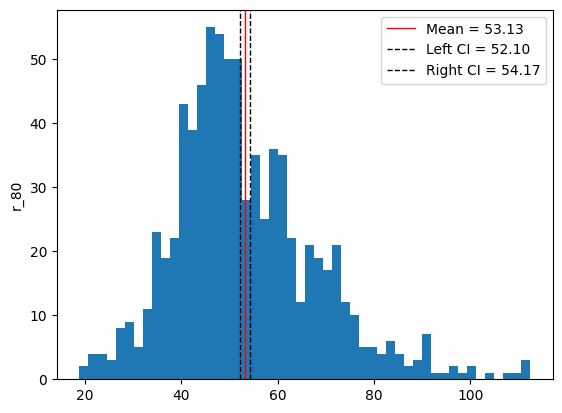

mean =  53.134105908634204  ±  0.5301026068352863


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


processed_table = 'petrofit_processed.parquet'


def show_stats(t):
  mean = np.mean(t)
  std = np.std(t)
  n = len(t)

  # Compute standard error of the mean (SEM)
  sem = std / np.sqrt(n)

  # Compute 95% confidence interval
  z_95 = 1.96  # z-score for 95% confidence
  margin_error = z_95 * sem
  left_ci = mean - margin_error
  right_ci = mean + margin_error

  plt.hist(t, bins=50)
  plt.axvline(mean, color='red', linestyle='solid', linewidth=1, label=f'Mean = {mean:.2f}')
  plt.axvline(left_ci, color='black', linestyle='dashed', linewidth=1, label=f'Left CI = {left_ci:.2f}')
  plt.axvline(right_ci, color='black', linestyle='dashed', linewidth=1, label=f'Right CI = {right_ci:.2f}')
  plt.ylabel("r_80")
  plt.legend()
  plt.show()
  print("mean = ", mean, " ± ",sem)

df = pd.read_parquet(processed_table)
filtered_df = df[df['processed'] == True]
show_stats(filtered_df["r_80"])


Overlay all processed galaxies to see how they fit into 120x120 central square.

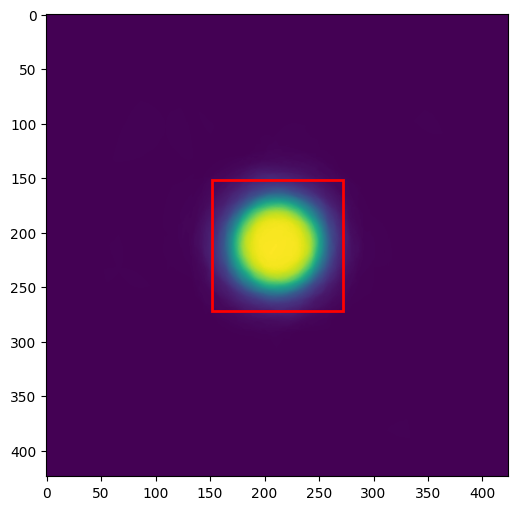

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


df_raw = pd.read_parquet("petrofit_processed.parquet")
df = df_raw[df_raw['processed']]

w, h = 424, 424
image = np.zeros((w, h))  # Initialize with zeros
y, x = np.indices((w, h))
for row in df.itertuples():
  cx, cy = df.at[row.Index, 'position_X'] + w/2, df.at[row.Index, 'position_Y'] + h/2
  elong = df.at[row.Index, 'elong']
  a, b = df.at[row.Index, 'r_80'], df.at[row.Index, 'r_80'] / elong
  theta = df.at[row.Index, 'theta']

  x_shifted = x - cx
  y_shifted = y - cy
  x_rot = x_shifted * np.cos(theta) + y_shifted * np.sin(theta)
  y_rot = -x_shifted * np.sin(theta) + y_shifted * np.cos(theta)
  ellipse_mask = (x_rot**2 / a**2) + (y_rot**2 / b**2) <= 1
  image[ellipse_mask] += 1

image_min, image_max = image.min(), image.max()
image_scaled = 255 * (image - image_min) / (image_max - image_min)
image_scaled = image_scaled.astype(np.uint8)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image_scaled)
rect = patches.Rectangle((424//2-60, 424//2-60), 120, 120, linewidth=2, edgecolor='red', facecolor="none")
ax.add_patch(rect)

plt.show()